In [1]:
%load_ext autoreload
%autoreload 2

# Imports
import json
import tensorflow as tf
import recommender
from matrix import ReportTechniqueMatrix
from matrix_builder import ReportTechniqueMatrixBuilder
import random
import math
import importlib
import pandas as pd
import numpy as np
import sklearn.manifold
import matplotlib.pyplot as plt
from utils import get_mitre_technique_ids_to_names

tf.config.run_functions_eagerly(True)

assert tf.executing_eagerly()

importlib.reload(recommender)

<module 'recommender' from '/Users/mjturner/code/technique-inference-engine/models/recommender/__init__.py'>

In [2]:
def train_test_split(indices: list, values: list, test_ratio: float=0.1) -> tuple:
    n = len(indices)
    assert len(values) == n

    indices_for_test_set = frozenset(random.sample(range(n), k=math.floor(test_ratio * n)))

    train_indices = []
    test_indices = []
    train_values = []
    test_values = []

    for i in range(n):
        if i in indices_for_test_set:
            test_indices.append(indices[i])
            test_values.append(values[i])
        else:
            train_indices.append(indices[i])
            train_values.append(values[i])

    return train_indices, train_values, test_indices, test_values


In [3]:
def view_prediction_performance_table_for_report(
        train_data: ReportTechniqueMatrix,
        test_data: ReportTechniqueMatrix,
        predictions: pd.DataFrame,
        report_id: int,
    ) -> pd.DataFrame:
    """Gets a dataframe to visualize the training data, test data, and predictions for a report."""
    # 1. training_data
    training_dataframe = train_data.to_pandas()
    report_train_techniques = training_dataframe.loc[report_id]
    report_train_techniques.name = "training_data"

    # 2. predictions
    predicted_techniques = predictions.loc[report_id]
    predicted_techniques.name = "predictions"

    # now test data
    test_dataframe = test_data.to_pandas()
    report_test_techniques = test_dataframe.loc[report_id]
    report_test_techniques.name = "test_data"

    report_data = pd.concat((predicted_techniques, report_train_techniques, report_test_techniques), axis=1)

    # add name for convenience
    all_mitre_technique_ids_to_names = get_mitre_technique_ids_to_names("../enterprise-attack.json")
    report_data.loc[:, "technique_name"] = report_data.apply(lambda row: all_mitre_technique_ids_to_names.get(row.name), axis=1)

    return report_data


In [4]:
test_ratio = 0.1
embedding_dimension = 10

data_builder = ReportTechniqueMatrixBuilder(
    combined_dataset_filepath="../data/combined_dataset_full_frequency.json",
    enterprise_attack_filepath="../enterprise-attack.json",
)
data = data_builder.build()

train_indices = frozenset(random.sample(data.indices, k=math.floor((1-test_ratio) * len(data.indices))))
test_indices = frozenset(data.indices).difference(train_indices)

training_data = data.mask(train_indices)
test_data = data.mask(test_indices)

# train
model = recommender.FactorizationRecommender(m=data.m, n=data.n, k=embedding_dimension)
model.fit(training_data.to_sparse_tensor(), num_iterations=1000, learning_rate=10., regularization_coefficient=0.1, gravity_coefficient=0.0)

evaluation = model.evaluate(test_data.to_sparse_tensor())
print("MSE Error", evaluation)

predictions = model.predict()

predictions_dataframe = pd.DataFrame(predictions, columns=data.technique_ids)


MSE Error 0.065360025


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 191 samples in 0.000s...


[t-SNE] Computed neighbors for 191 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 191 / 191
[t-SNE] Mean sigma: 0.000057
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.644371
[t-SNE] KL divergence after 500 iterations: 0.466631


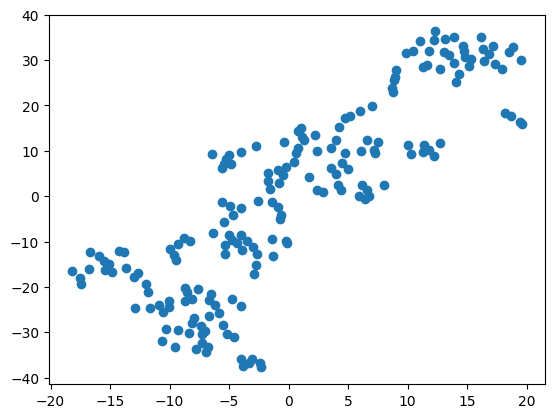

In [5]:
def make_tsne_embeddings(embeddings: np.ndarray) -> tuple[np.array, np.array]:
  """Create 2D representation of embeddings using t-SNE.

  Args:
    embeddings: an mxk array of m embeddings in k-dimensional space.

  Returns:
    A tuple of the form x_1, x_2 where x_1 and x_2 are length m
    such that (x_1[i], x_2[i]) is the 2-dimensional point cotnaining the 2-dimensional
    repsresentation for embeddings[i, :].
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2,
      perplexity=10,
      metric='cosine',
      # early_exaggeration=10.0,
      # init='pca',
      verbose=True,
      n_iter=500
  )

  V_proj = tsne.fit_transform(embeddings)
  x = V_proj[:, 0]
  y = V_proj[:, 1]

  return x, y

x_1, x_2 = make_tsne_embeddings(model.U)

plt.scatter(x_1, x_2)
plt.show()

In [6]:
# get best and worst test performance
test_ndarray = test_data.to_numpy()
predictions_ndarray = predictions_dataframe.to_numpy()
# where test data, use predictions, else, fill with Nan
test_performance = np.mean(np.square(predictions_ndarray - test_ndarray), axis=1, where=test_ndarray > 0.5)

best_test_perf = np.nanargmin(test_performance, )
worst_test_perf = np.nanargmax(test_performance)

best_performance_results = view_prediction_performance_table_for_report(
    train_data=training_data,
    test_data=test_data,
    predictions=predictions_dataframe,
    report_id=best_test_perf
)

worst_performance_results = view_prediction_performance_table_for_report(
    train_data=training_data,
    test_data=test_data,
    predictions=predictions_dataframe,
    report_id=worst_test_perf
)

/opt/homebrew/anaconda3/envs/tie/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/envs/tie/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [7]:
print(best_performance_results.sort_values("test_data", ascending=False).head(15))

           predictions  training_data  test_data  \
T1078.002     0.997682            0.0        1.0   
T1003.003     0.476667            0.0        0.0   
T1595.002     0.658774            0.0        0.0   
T1568.002     0.287291            0.0        0.0   
T1134.001     0.500125            0.0        0.0   
T1561         0.355860            0.0        0.0   
T1056         0.477569            0.0        0.0   
T1546.003     0.315644            0.0        0.0   
T1003         0.496412            0.0        0.0   
T1561.001     0.423142            0.0        0.0   
T1553.006     0.000260            0.0        0.0   
T1482         0.490606            0.0        0.0   
T1110         1.038576            0.0        0.0   
T1027.002     1.085995            0.0        0.0   
T1562.001     1.087301            0.0        0.0   

                                              technique_name  
T1078.002                                    Domain Accounts  
T1003.003                                

In [8]:
print(worst_performance_results.sort_values("test_data", ascending=False).head(15))

           predictions  training_data  test_data  \
T1106        -0.068399            0.0        1.0   
T1003.003    -0.043437            0.0        0.0   
T1595.002    -0.041558            0.0        0.0   
T1568.002    -0.015528            0.0        0.0   
T1134.001    -0.059807            0.0        0.0   
T1561        -0.044522            0.0        0.0   
T1056        -0.018223            0.0        0.0   
T1546.003    -0.038773            0.0        0.0   
T1003        -0.045067            0.0        0.0   
T1561.001    -0.046921            0.0        0.0   
T1553.006    -0.000044            0.0        0.0   
T1482        -0.034485            0.0        0.0   
T1110        -0.059558            0.0        0.0   
T1027.002    -0.066632            0.0        0.0   
T1562.001    -0.065202            0.0        0.0   

                                              technique_name  
T1106                                             Native API  
T1003.003                                